In [61]:
import pandas as pd
import requests as r
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample

In [62]:
api_key = "aBIdeyJp18dnYHxOLyICUOdCfrz7C2g1VFRdCQbx"


In [63]:
url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=SPV&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"


In [64]:
try:
    (request := r.get(url))
    print(request.text[0:1000])
except Exception as e:
    print(e)

{"response":{"total":106,"dateFormat":"YYYY-MM","frequency":"monthly","data":[{"period":"2022-12","location":"MO","stateDescription":"Missouri","sectorid":99,"sectorDescription":"All Sectors","fueltypeid":"SPV","fuelTypeDescription":"solar photovoltaic","generation":7.20169,"generation-units":"thousand megawatthours"},{"period":"2022-11","location":"MO","stateDescription":"Missouri","sectorid":99,"sectorDescription":"All Sectors","fueltypeid":"SPV","fuelTypeDescription":"solar photovoltaic","generation":9.47591,"generation-units":"thousand megawatthours"},{"period":"2022-10","location":"MO","stateDescription":"Missouri","sectorid":99,"sectorDescription":"All Sectors","fueltypeid":"SPV","fuelTypeDescription":"solar photovoltaic","generation":14.40455,"generation-units":"thousand megawatthours"},{"period":"2022-09","location":"MO","stateDescription":"Missouri","sectorid":99,"sectorDescription":"All Sectors","fueltypeid":"SPV","fuelTypeDescription":"solar photovoltaic","generation":15.425

In [65]:
json_data = request.json()
json_data

{'response': {'total': 106,
  'dateFormat': 'YYYY-MM',
  'frequency': 'monthly',
  'data': [{'period': '2022-12',
    'location': 'MO',
    'stateDescription': 'Missouri',
    'sectorid': 99,
    'sectorDescription': 'All Sectors',
    'fueltypeid': 'SPV',
    'fuelTypeDescription': 'solar photovoltaic',
    'generation': 7.20169,
    'generation-units': 'thousand megawatthours'},
   {'period': '2022-11',
    'location': 'MO',
    'stateDescription': 'Missouri',
    'sectorid': 99,
    'sectorDescription': 'All Sectors',
    'fueltypeid': 'SPV',
    'fuelTypeDescription': 'solar photovoltaic',
    'generation': 9.47591,
    'generation-units': 'thousand megawatthours'},
   {'period': '2022-10',
    'location': 'MO',
    'stateDescription': 'Missouri',
    'sectorid': 99,
    'sectorDescription': 'All Sectors',
    'fueltypeid': 'SPV',
    'fuelTypeDescription': 'solar photovoltaic',
    'generation': 14.40455,
    'generation-units': 'thousand megawatthours'},
   {'period': '2022-09',


In [66]:
solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [67]:
solar_generation.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,generation,generation-units
0,2022-12,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,7.20169,thousand megawatthours
1,2022-11,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,9.47591,thousand megawatthours
2,2022-10,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,14.40455,thousand megawatthours
3,2022-09,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,15.42541,thousand megawatthours
4,2022-08,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,16.33000,thousand megawatthours


In [68]:
solar_generation.period = pd.to_datetime(solar_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

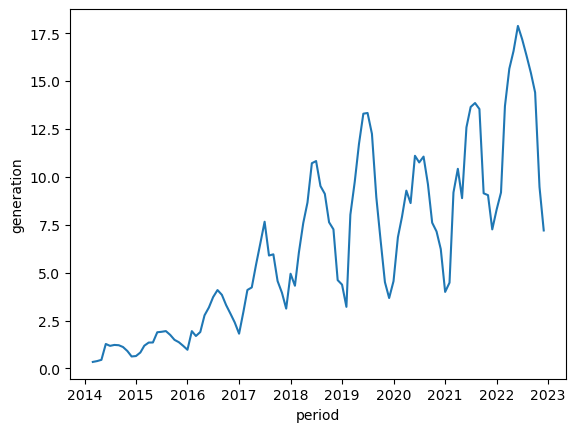

In [69]:
sns.lineplot(x="period",y="generation",data=solar_generation)

In [93]:
index=pd.DatetimeIndex(solar_generation.period).to_period("M")
y = pd.Series(solar_generation.generation.values, index=index)
arima = ARIMA(y,order=(2,0,2)).fit()

C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [94]:
index

PeriodIndex(['2022-12', '2022-11', '2022-10', '2022-09', '2022-08', '2022-07',
             '2022-06', '2022-05', '2022-04', '2022-03',
             ...
             '2014-12', '2014-11', '2014-10', '2014-09', '2014-08', '2014-07',
             '2014-06', '2014-05', '2014-04', '2014-03'],
            dtype='period[M]', name='period', length=106)

In [91]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  106
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -185.107
Date:                Wed, 15 Mar 2023   AIC                            382.214
Time:                        20:12:21   BIC                            398.195
Sample:                             0   HQIC                           388.691
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0644      1.997      3.037      0.002       2.150       9.978
ar.L1          1.5060      0.171      8.830      0.000       1.172       1.840
ar.L2         -0.5965      0.167     -3.565      0.0

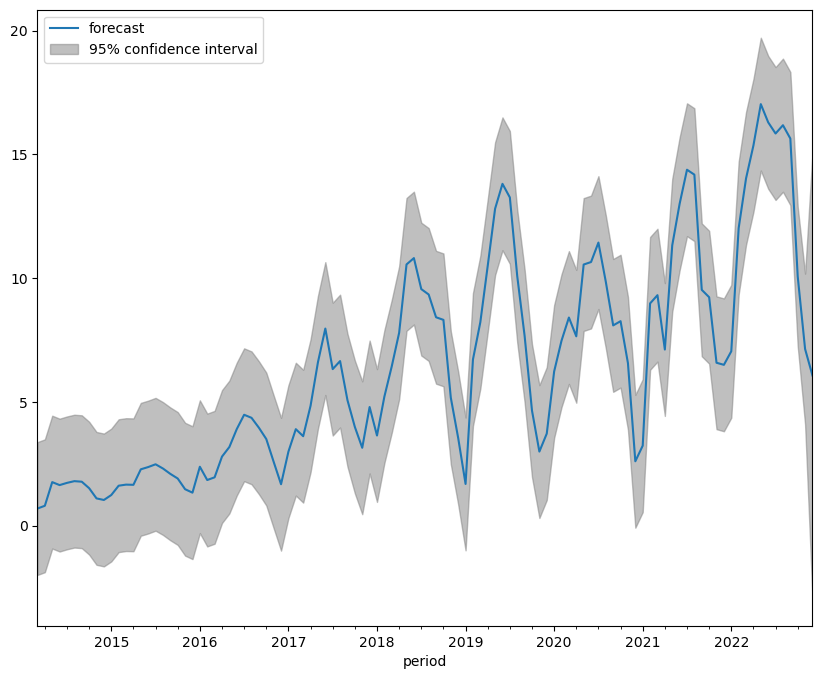

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima, ax=ax)
legend = ax.legend(loc="upper left")